In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
from PIL import Image

import json
import csv

from sklearn.model_selection import train_test_split

from tqdm import tqdm

##########################
### SETTINGS
##########################
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Others
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

# Path
PATH = './carplate_ocr/'
IMAGES_PATH = PATH+'images/'
SAVE_PATH  = PATH+"ocr.pth"
LABEL_PATH = PATH+'groundtruth.csv'

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

with open(LABEL_PATH) as file:
  dataframe = pd.read_csv(file,names=['filenames','states','strings'])

tmp_dataframe, test_dataframe = train_test_split(dataframe, test_size=0.2)
train_dataframe, validation_dataframe = train_test_split(tmp_dataframe, test_size=0.25)

train_dataframe = train_dataframe.reset_index(drop=True)
validation_dataframe = validation_dataframe.reset_index(drop=True)
test_dataframe = test_dataframe.reset_index(drop=True)


#print(len(states), states)
#print(train_dataframe, validation_dataframe, test_dataframe)
#tokens = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ ") + ["<START>", "<END>"]
#print(len(tokens))
#print(dataframe.loc[0,['filenames']].item())
#dataframe['strings_trans'] = dataframe['strings'].map(lambda x: [tokens.index(c) for c in x])
#print(dataframe.strings_trans[[2,35,111]])

#print(dataframe)
print(DEVICE)

cuda:0


In [7]:
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader

class PlateDataset(Dataset):
    # Charator tokens
    __tokens__ = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ ") + ["<START>", "<END>"]
    __states__ = ["AK", "AL", "AR", "AS", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
            "GU", "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI",
            "MN", "MO", "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH",
            "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VI", "VT",
            "WA", "WI", "WV", "WY"]
    __start_token__ = 36
    __end_token__ = 37

    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe  = dataframe
        self.images_dir = images_dir
        self.transform  = transform
        self.dataframe['states_trans']  = dataframe['states'].map(lambda x: self.__states__.index(x.upper()))
        self.dataframe['strings_trans'] = dataframe['strings'].map(lambda x: [self.__tokens__.index(c) for c in x])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path    = os.path.join(self.images_dir, self.dataframe.filenames[idx])
        image       = Image.open(img_path)
        filename    = self.dataframe.filenames[idx]
        state       = self.dataframe.states_trans[idx]
        #string      = self.dataframe.strings_trans[idx]
        if self.transform:
            image = self.transform(image)

        return filename, image, state


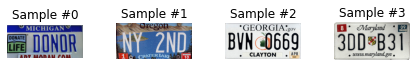

In [3]:
import matplotlib.pyplot as plt

train_dataset = PlateDataset(dataframe=train_dataframe,images_dir=IMAGES_PATH)

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[1])
    if i==3:
        plt.show()
        break

In [4]:
from torchvision import models

def classifier(D_out):
  resnet18 = models.resnet18()
  num_ftrs = resnet18.fc.in_features 
  resnet18.fc = nn.Linear(num_ftrs, D_out) 

  return resnet18

In [5]:
model = classifier(14)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
train_dataset = PlateDataset(dataframe=train_dataframe,images_dir=IMAGES_PATH,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validation_dataset = PlateDataset(dataframe=validation_dataframe,images_dir=IMAGES_PATH,transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=10, shuffle=True)

epochs = 2
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0    
    val_running_loss = 0.0
    val_running_corrects = 0.0

    if(e>0):
        model = classifier(14)
        model.load_state_dict(torch.load(SAVE_PATH))
        model.to(DEVICE)

    for filenames, images, labels in tqdm(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        outputs = outputs.to(DEVICE)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += (preds == labels).sum().item()
    else:
        with torch.no_grad():
            for val_filename, val_images, val_labels in tqdm(validation_loader):
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)
                val_outputs = model(val_images)
                val_outputs = val_outputs.to(DEVICE)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += (val_preds == val_labels).sum().item()

    torch.save(model.state_dict(), SAVE_PATH)
    
    epoch_loss = running_loss/len(train_dataset)
    epoch_acc = running_corrects/ len(train_dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_dataset)
    val_epoch_acc = val_running_corrects/ len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch :', (e+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_acc))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))

  0%|          | 0/45 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered